# Project 4: K Means Clustering

### Import Python Libraries

In [141]:
# Import the Python Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


### Load Data

In [143]:
df = pd.read_csv("datasets/imdb_top_2000_movies.csv")

In [145]:
df.head()

,Movie Name,Release Year,Duration,IMDB Rating,Metascore,Votes,Genre,Director,Cast,Gross
0,The Godfather,1972,175,9.2,100.0,"2,002,655","Crime, Drama",Francis Ford Coppola,Marlon Brando,$134.97M
1,The Godfather Part II,1974,202,9.0,90.0,"1,358,608","Crime, Drama",Francis Ford Coppola,Al Pacino,$57.30M
2,Ordinary People,1980,124,7.7,86.0,"56,476",Drama,Robert Redford,Donald Sutherland,$54.80M
3,Lawrence of Arabia,1962,218,8.3,100.0,"313,044","Adventure, Biography, Drama",David Lean,Peter O'Toole,$44.82M
4,Straw Dogs,1971,113,7.4,73.0,"64,331","Crime, Drama, Thriller",Sam Peckinpah,Dustin Hoffman,NaN


### Pre-Processing Data

In [147]:
df.shape # 2000 entries with 10 features

(2000, 10)

In [149]:
df.isnull().sum() # 97 null values under the Gross feature and 81 null values under the Metascore feature

Movie Name       0
Release Year     0
Duration         0
IMDB Rating      0
Metascore       81
Votes            0
Genre            0
Director         0
Cast             0
Gross           97
dtype: int64

In [151]:
df = df.dropna() # Dropped all null values (130 rows) and was confident about this decision because our dataset is very large

In [153]:
df.shape 

(1870, 10)

In [155]:
# Create the one-hot encoding for genres used Chat-GPT4 to assist within this process

df['Genre'] = df['Genre'].str.split(', ')

all_genres = set([genre for genres in df['Genre'] for genre in genres])

for genre in all_genres:
    df[genre] = df['Genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original Genre column after hot encoding
df = df.drop(columns=['Genre'])

print(df)

                              Movie Name Release Year  Duration  IMDB Rating  \
0                          The Godfather         1972       175          9.2   
1                  The Godfather Part II         1974       202          9.0   
2                        Ordinary People         1980       124          7.7   
3                     Lawrence of Arabia         1962       218          8.3   
5     Close Encounters of the Third Kind         1977       138          7.6   
...                                  ...          ...       ...          ...   
1995                  The Young Victoria         2009       105          7.2   
1996                         Tooth Fairy       I 2010       101          5.0   
1997                      The Informant!         2009       108          6.5   
1998                     Youth in Revolt         2009        90          6.4   
1999                          Quarantine         2008        89          6.0   

      Metascore      Votes             

In [157]:
df["Votes"] = df["Votes"].replace(",", "", regex=True).apply(pd.to_numeric) # converting Votes from object to int



In [159]:

# Clean and convert the "Gross" column
def clean_gross(value):
    value = value.replace("$", "").replace(",", "")
    if 'M' in value:
        return int(float(value.replace('M', '')) * 1_000_000)
    elif 'K' in value:
        return int(float(value.replace('K', '')) * 1_000)
    else:
        return int(float(value))

df["Gross"] = df["Gross"].apply(clean_gross)

# Show the result
print(df)


                              Movie Name Release Year  Duration  IMDB Rating  \
0                          The Godfather         1972       175          9.2   
1                  The Godfather Part II         1974       202          9.0   
2                        Ordinary People         1980       124          7.7   
3                     Lawrence of Arabia         1962       218          8.3   
5     Close Encounters of the Third Kind         1977       138          7.6   
...                                  ...          ...       ...          ...   
1995                  The Young Victoria         2009       105          7.2   
1996                         Tooth Fairy       I 2010       101          5.0   
1997                      The Informant!         2009       108          6.5   
1998                     Youth in Revolt         2009        90          6.4   
1999                          Quarantine         2008        89          6.0   

      Metascore    Votes              D

In [161]:
df.head() # Hot encoding labels have been added inplace of the genere feature

,Movie Name,Release Year,Duration,IMDB Rating,Metascore,Votes,Director,Cast,Gross,Mystery,...,Music,History,Family,Animation,War,Western,Action,Adventure,Sci-Fi,Horror
0,The Godfather,1972,175,9.2,100.0,2002655,Francis Ford Coppola,Marlon Brando,134970000,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather Part II,1974,202,9.0,90.0,1358608,Francis Ford Coppola,Al Pacino,57300000,0,...,0,0,0,0,0,0,0,0,0,0
2,Ordinary People,1980,124,7.7,86.0,56476,Robert Redford,Donald Sutherland,54800000,0,...,0,0,0,0,0,0,0,0,0,0
3,Lawrence of Arabia,1962,218,8.3,100.0,313044,David Lean,Peter O'Toole,44820000,0,...,0,0,0,0,0,0,0,1,0,0
5,Close Encounters of the Third Kind,1977,138,7.6,90.0,216050,Steven Spielberg,Richard Dreyfuss,132090000,0,...,0,0,0,0,0,0,0,0,1,0


In [163]:
df

,Movie Name,Release Year,Duration,IMDB Rating,Metascore,Votes,Director,Cast,Gross,Mystery,...,Music,History,Family,Animation,War,Western,Action,Adventure,Sci-Fi,Horror
0,The Godfather,1972,175,9.2,100.0,2002655,Francis Ford Coppola,Marlon Brando,134970000,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather Part II,1974,202,9.0,90.0,1358608,Francis Ford Coppola,Al Pacino,57300000,0,...,0,0,0,0,0,0,0,0,0,0
2,Ordinary People,1980,124,7.7,86.0,56476,Robert Redford,Donald Sutherland,54800000,0,...,0,0,0,0,0,0,0,0,0,0
3,Lawrence of Arabia,1962,218,8.3,100.0,313044,David Lean,Peter O'Toole,44820000,0,...,0,0,0,0,0,0,0,1,0,0
5,Close Encounters of the Third Kind,1977,138,7.6,90.0,216050,Steven Spielberg,Richard Dreyfuss,132090000,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,The Young Victoria,2009,105,7.2,64.0,66235,Jean-Marc Vallée,Emily Blunt,11000000,0,...,0,1,0,0,0,0,0,0,0,0
1996,Tooth Fairy,I 2010,101,5.0,36.0,49527,Michael Lembeck,Dwayne Johnson,60020000,0,...,0,0,1,0,0,0,0,0,0,0
1997,The Informant!,2009,108,6.5,66.0,67318,Steven Soderbergh,Matt Damon,33310000,0,...,0,0,0,0,0,0,0,0,0,0
1998,Youth in Revolt,2009,90,6.4,63.0,75956,Miguel Arteta,Michael Cera,15280000,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
# Convert Release Year from string to integer
df['Release Year'] = pd.to_numeric(df['Release Year'], errors='coerce')
df = df.dropna(subset=['Release Year']).reset_index(drop=True)
df['Release Year'] = df['Release Year'].astype(int)

# Drop Movie Name, Director, and Cast as these will not provide valuable information for clustering 
df.drop(columns=["Movie Name", "Director", "Cast"],inplace=True)

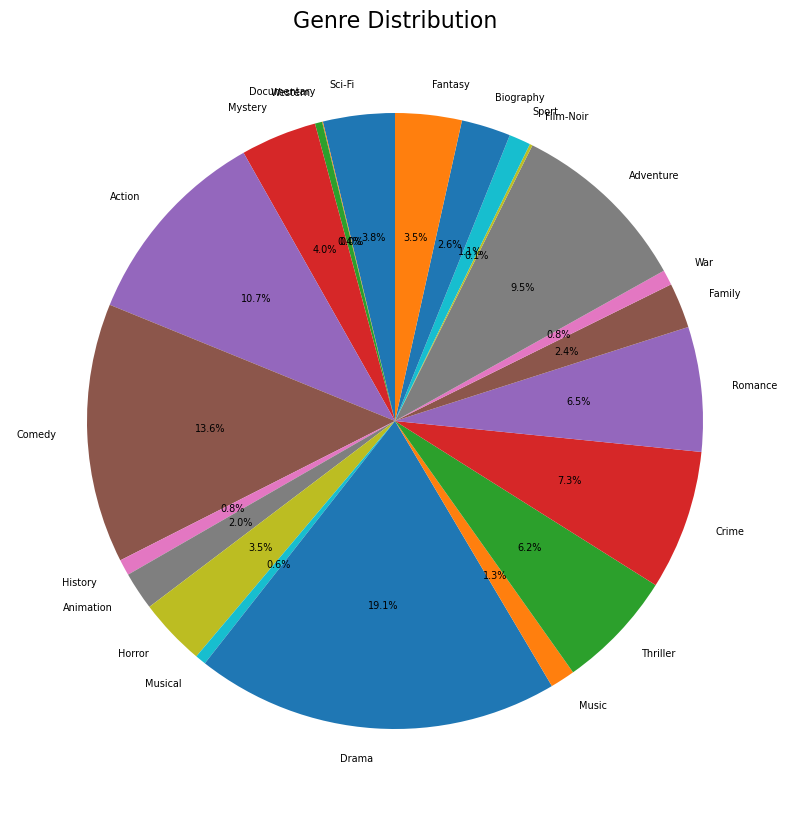

In [167]:

import matplotlib.pyplot as plt

mylabels = ['Sci-Fi', 'Documentary', 'Western', 'Mystery', 'Action',
          'Comedy', 'History', 'Animation', 'Horror', 'Musical', 'Drama', 'Music',
          'Thriller', 'Crime', 'Romance', 'Family', 'War', 'Adventure',
          'Film-Noir', 'Sport', 'Biography', 'Fantasy']

# Calculate the total value for each genre
y = df[['Sci-Fi', 'Documentary', 'Western', 'Mystery', 'Action', 
        'Comedy', 'History', 'Animation', 'Horror', 'Musical', 'Drama', 
        'Music', 'Thriller', 'Crime', 'Romance', 'Family', 'War', 
        'Adventure', 'Film-Noir', 'Sport', 'Biography', 'Fantasy']].sum()

# Set the figure size
plt.figure(figsize=(10, 10)) 

# Create the pie chart
plt.pie(y, labels=mylabels, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 7})
plt.title("Genre Distribution", fontsize=16)  
plt.show()


In [169]:
# Lets standardize the data to ensure that our features are all on the same scale
standardized_df = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df),columns = df.columns)
standardized_df.head()

,Release Year,Duration,IMDB Rating,Metascore,Votes,Gross,Mystery,Sport,Biography,Musical,...,Music,History,Family,Animation,War,Western,Action,Adventure,Sci-Fi,Horror
0,-1.880060,2.735433,2.493276,2.199201,6.165539,0.925713,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.188386,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.62402,-0.577989,-0.331385,-0.319963
1,-1.728401,3.948750,2.273656,1.636881,3.920043,-0.133962,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.188386,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.62402,-0.577989,-0.331385,-0.319963
2,-1.273424,0.443613,0.846126,1.411954,-0.619892,-0.168071,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.188386,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.62402,-0.577989,-0.331385,-0.319963
3,-2.638354,4.667752,1.504986,2.199201,0.274642,-0.304231,-0.342573,-0.175412,3.702339,-0.123091,...,-0.188386,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.62402,1.730138,-0.331385,-0.319963
4,-1.500912,1.072740,0.736316,1.636881,-0.063531,0.886421,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.188386,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.62402,-0.577989,3.017639,-0.319963


In [171]:
standardized_df.describe()

,Release Year,Duration,IMDB Rating,Metascore,Votes,Gross,Mystery,Sport,Biography,Musical,...,Music,History,Family,Animation,War,Western,Action,Adventure,Sci-Fi,Horror
count,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,...,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03,1.809000e+03
mean,3.142256e-15,-1.728241e-16,5.656062e-16,1.099790e-16,2.749474e-17,-5.695340e-17,2.749474e-17,5.498949e-17,5.695340e-17,-1.963910e-17,...,-3.927821e-18,4.222407e-17,-1.963910e-17,-2.945865e-17,-3.927821e-17,7.855641e-18,9.426769e-17,-6.284513e-17,-5.891731e-18,-9.819551e-18
std,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,...,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00,1.000277e+00
min,-5.292386e+00,-2.252645e+00,-4.973804e+00,-2.917907e+00,-7.908513e-01,-9.157237e-01,-3.425732e-01,-1.754116e-01,-2.700995e-01,-1.230915e-01,...,-1.883863e-01,-1.503717e-01,-2.581228e-01,-2.354271e-01,-1.464814e-01,-1.002509e-01,-6.240200e-01,-5.779886e-01,-3.313849e-01,-3.199634e-01
25%,-3.634701e-01,-7.247655e-01,-5.814042e-01,-7.248607e-01,-5.268539e-01,-6.619583e-01,-3.425732e-01,-1.754116e-01,-2.700995e-01,-1.230915e-01,...,-1.883863e-01,-1.503717e-01,-2.581228e-01,-2.354271e-01,-1.464814e-01,-1.002509e-01,-6.240200e-01,-5.779886e-01,-3.313849e-01,-3.199634e-01
50%,3.189952e-01,-1.855137e-01,7.745581e-02,6.154741e-03,-3.244603e-01,-2.900417e-01,-3.425732e-01,-1.754116e-01,-2.700995e-01,-1.230915e-01,...,-1.883863e-01,-1.503717e-01,-2.581228e-01,-2.354271e-01,-1.464814e-01,-1.002509e-01,-6.240200e-01,-5.779886e-01,-3.313849e-01,-3.199634e-01
75%,6.981426e-01,4.885509e-01,7.363158e-01,7.371702e-01,9.969826e-02,2.952561e-01,-3.425732e-01,-1.754116e-01,-2.700995e-01,-1.230915e-01,...,-1.883863e-01,-1.503717e-01,-2.581228e-01,-2.354271e-01,-1.464814e-01,-1.002509e-01,1.602513e+00,1.730138e+00,-3.313849e-01,-3.199634e-01
max,1.001461e+00,5.566505e+00,2.603086e+00,2.199201e+00,9.207873e+00,9.460147e+00,2.919084e+00,5.700877e+00,3.702339e+00,8.124038e+00,...,5.308241e+00,6.650188e+00,3.874126e+00,4.247600e+00,6.826805e+00,9.974969e+00,1.602513e+00,1.730138e+00,3.017639e+00,3.125357e+00


## Visulizations

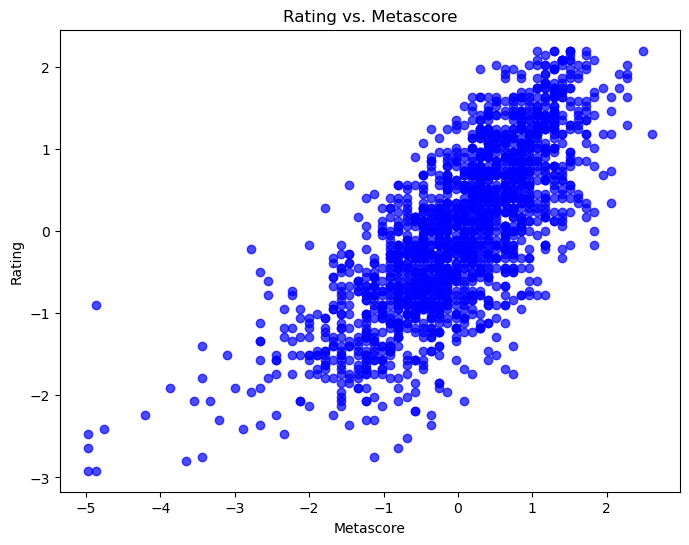

In [173]:
plt.figure(figsize=(8, 6))
plt.scatter(standardized_df['IMDB Rating'], standardized_df['Metascore'], alpha=0.7, c='blue')
plt.xlabel('Metascore')
plt.ylabel('Rating')
plt.title('Rating vs. Metascore')
plt.show()


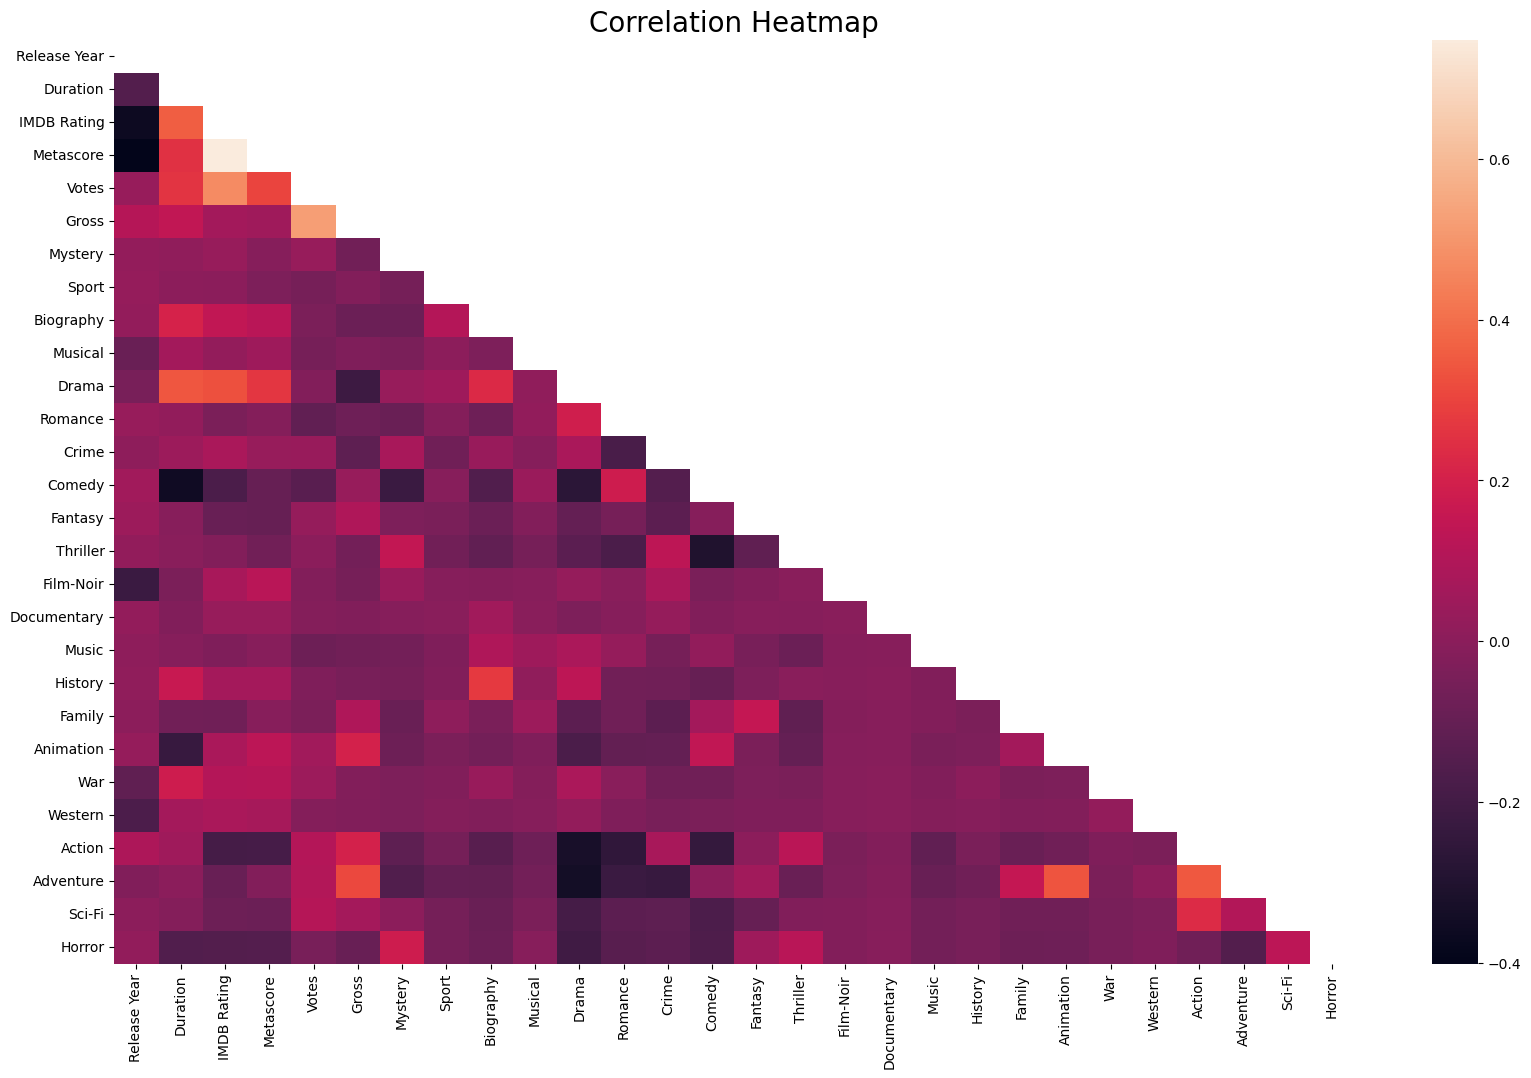

In [175]:
# Get the correlations
corr = df.corr()

# Create a mask so that way we only see the lower half of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 12))

sns.heatmap(corr, mask=mask)

plt.title('Correlation Heatmap', fontsize=20)
plt.show()

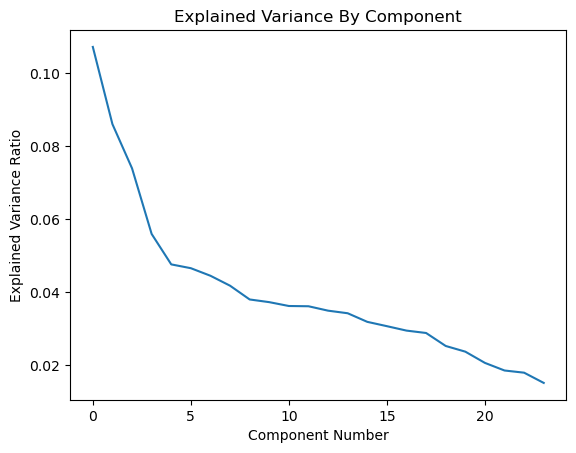

In [177]:
pca = PCA(n_components=0.95) # instead of us picking the number, let it pick 
pca.fit(standardized_df)

# Get percentage of variance explained by each of the selected components
plt.plot(pca.explained_variance_ratio_) 

plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance By Component')

plt.show()

In [179]:
pca = PCA(n_components = 5, random_state = 42) 

# Fit PCA to the data, transform the data and then make it a dataframe we know and love
pca_df = pd.DataFrame(pca.fit_transform(standardized_df))

pca_df.shape

(1809, 5)

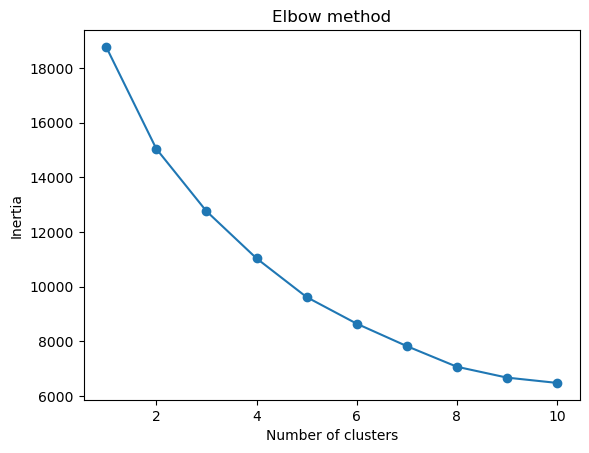

In [181]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=5)
    clusters = kmeans.fit_predict(pca_df)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

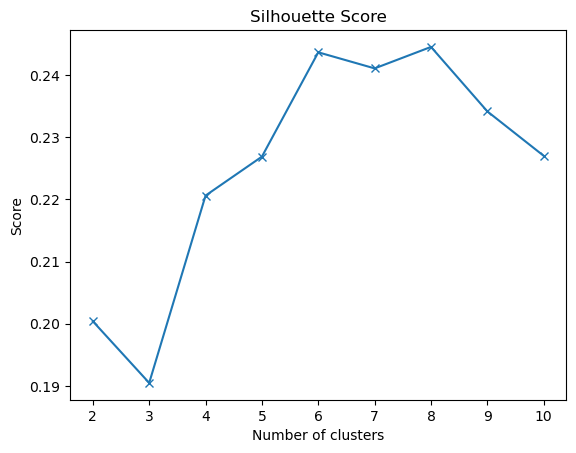

In [183]:
silhouette_scores = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    clusters = kmeans.fit_predict(pca_df)
    silhouette_scores.append(silhouette_score(pca_df, clusters))

plt.plot(range(2,11), silhouette_scores, marker='x')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

### Modeling

In [189]:
# Create the model using two clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the model
kmeans.fit(pca_df)

# get what cluster the model thinks the points belong to and add it to our original dataframe
standardized_df["Clusters"] = kmeans.predict(pca_df)

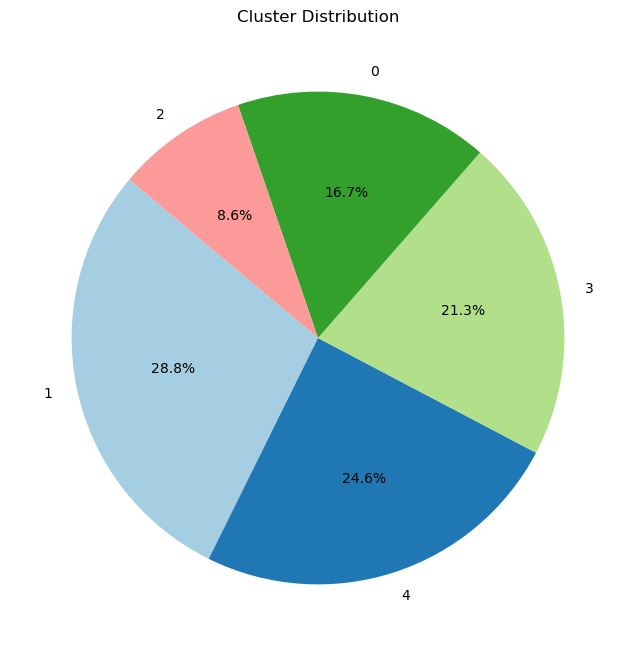

In [191]:
cluster_counts = standardized_df['Clusters'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Cluster Distribution')
plt.show()

In [193]:
standardized_df

,Release Year,Duration,IMDB Rating,Metascore,Votes,Gross,Mystery,Sport,Biography,Musical,...,History,Family,Animation,War,Western,Action,Adventure,Sci-Fi,Horror,Clusters
0,-1.880060,2.735433,2.493276,2.199201,6.165539,0.925713,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.624020,-0.577989,-0.331385,-0.319963,4
1,-1.728401,3.948750,2.273656,1.636881,3.920043,-0.133962,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.624020,-0.577989,-0.331385,-0.319963,4
2,-1.273424,0.443613,0.846126,1.411954,-0.619892,-0.168071,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.624020,-0.577989,-0.331385,-0.319963,4
3,-2.638354,4.667752,1.504986,2.199201,0.274642,-0.304231,-0.342573,-0.175412,3.702339,-0.123091,...,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.624020,1.730138,-0.331385,-0.319963,4
4,-1.500912,1.072740,0.736316,1.636881,-0.063531,0.886421,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.624020,-0.577989,3.017639,-0.319963,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,0.925631,-0.679828,-0.691214,-1.512108,-0.553847,-0.395777,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,1.602513,-0.577989,-0.331385,-0.319963,3
1805,0.925631,-0.410202,0.297076,0.174851,-0.585867,-0.765647,-0.342573,-0.175412,3.702339,-0.123091,...,6.650188,-0.258123,-0.235427,-0.146481,-0.100251,-0.624020,-0.577989,-0.331385,-0.319963,4
1806,0.925631,-0.275389,-0.471594,0.287315,-0.582091,-0.461265,-0.342573,-0.175412,3.702339,-0.123091,...,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.624020,-0.577989,-0.331385,-0.319963,1
1807,0.925631,-1.084267,-0.581404,0.118619,-0.551974,-0.707254,-0.342573,-0.175412,-0.270099,-0.123091,...,-0.150372,-0.258123,-0.235427,-0.146481,-0.100251,-0.624020,-0.577989,-0.331385,-0.319963,1


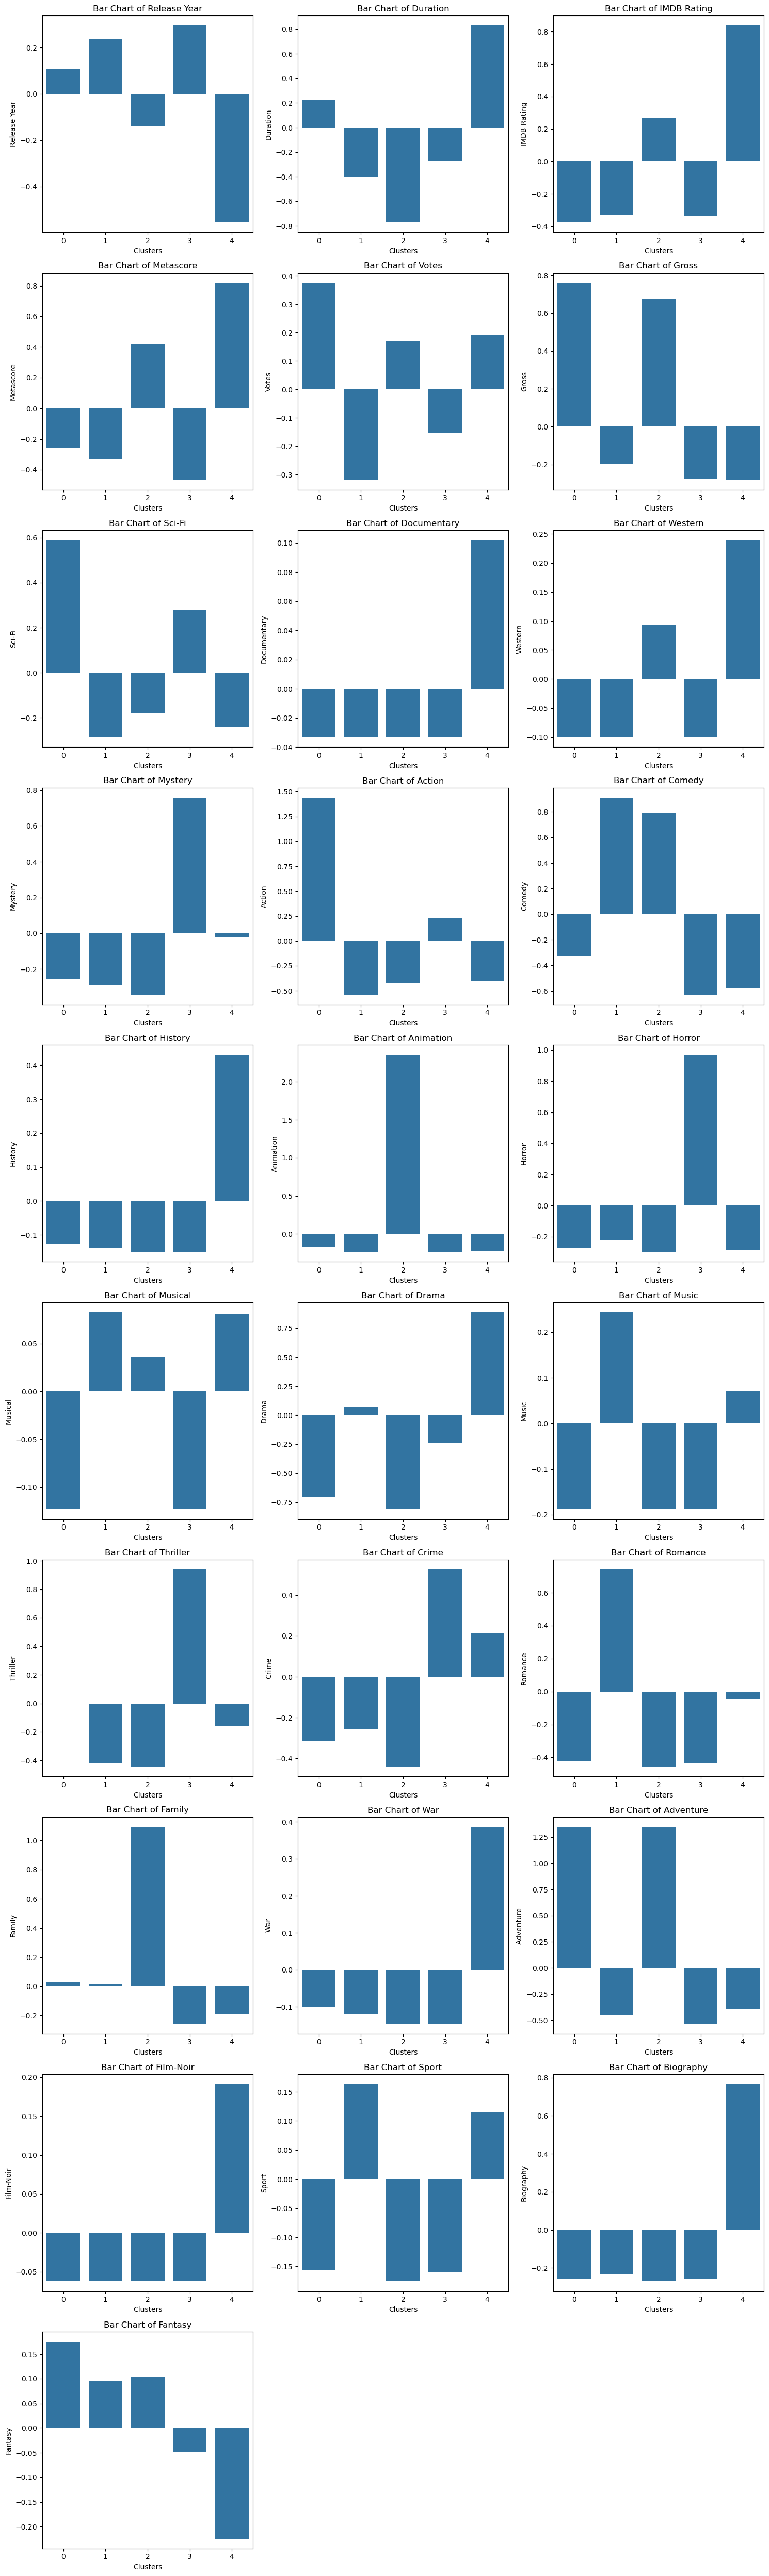

In [195]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Define the subset
subset = ['Release Year', 'Duration', 'IMDB Rating', 'Metascore', 'Votes',
          'Gross', 'Sci-Fi', 'Documentary', 'Western', 'Mystery', 'Action',
          'Comedy', 'History', 'Animation', 'Horror', 'Musical', 'Drama', 'Music',
          'Thriller', 'Crime', 'Romance', 'Family', 'War', 'Adventure',
          'Film-Noir', 'Sport', 'Biography', 'Fantasy']

# Calculate number of rows and columns needed
num_features = len(subset)
num_cols = 3  # Fixed number of columns
num_rows = math.ceil(num_features / num_cols)  # Calculate rows needed

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axs = axs.flatten()  # Flatten to a 1D array for easy indexing

# Plot each feature as a bar chart
for i, column in enumerate(subset):
    # Calculate the mean value for each cluster
    mean_values = standardized_df.groupby("Clusters")[column].mean()
    
    # Plot the bar chart
    sns.barplot(x=mean_values.index, y=mean_values.values, ax=axs[i])
    
    axs[i].set_title(f'Bar Chart of {column}')
    axs[i].set_xlabel('Clusters')
    axs[i].set_ylabel(column)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()
